# Automated trading : find the fastest lines to the Exchange

This notebook analyses a PCAP file containing the same pricing data received from 4 different servers over UDP multicast.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scapy.all import *

Load the PCAP file and extract the sessions.

In [14]:
input_pcap = "pcap/prices.pcap"
pc = rdpcap(input_pcap)
sessions = pc.sessions()
print("\nNumber of sessions in pcap file =", len(sessions), "\n")
for session_name in sorted(sessions):
    print("- session name =>", session_name)


Number of sessions in pcap file = 4 

- session name => UDP 10.10.10.1:33000 > 239.22.0.1:51000
- session name => UDP 10.10.10.2:33000 > 239.22.0.2:51000
- session name => UDP 10.10.10.3:33000 > 239.22.0.3:51000
- session name => UDP 10.10.10.4:33000 > 239.22.0.4:51000


Prepare the prices dict: it will be used to create the pandas dataframe.

In [15]:
price_label = 'price'
arrival_label = 'arrival'
src_label = 'src'
prices = { price_label: [], arrival_label: [], src_label: [] }
print("\nKeys:", list(prices.keys()))


Keys: ['price', 'arrival', 'src']


Populate the prices dict.

In [16]:
n = 0
for session_name in sessions:
    for packet in sessions[session_name]:
        price = packet[UDP].payload.load
        arrival = packet.time
        src = packet.getlayer(IP).src
        prices[price_label].append(price)
        prices[arrival_label].append(float(arrival))
        prices[src_label].append(src)
        n += 1

print("\nNb of rows =", n)



Nb of rows = 3989


Convert the prices dict into a pandas dataframe.

In [17]:
prices_df = pd.DataFrame(prices)
print(prices_df)

                                       price       arrival         src
0       b'Symbol: APPL Seqno: 0 Price: 1623'  1.473412e+09  10.10.10.4
1       b'Symbol: APPL Seqno: 1 Price: 1649'  1.473412e+09  10.10.10.4
2       b'Symbol: APPL Seqno: 2 Price: 1642'  1.473412e+09  10.10.10.4
3       b'Symbol: APPL Seqno: 3 Price: 1636'  1.473412e+09  10.10.10.4
4       b'Symbol: APPL Seqno: 4 Price: 1669'  1.473412e+09  10.10.10.4
...                                      ...           ...         ...
3984  b'Symbol: APPL Seqno: 995 Price: 1641'  1.473413e+09  10.10.10.2
3985  b'Symbol: APPL Seqno: 996 Price: 1581'  1.473413e+09  10.10.10.2
3986  b'Symbol: APPL Seqno: 997 Price: 1674'  1.473413e+09  10.10.10.2
3987  b'Symbol: APPL Seqno: 998 Price: 1680'  1.473413e+09  10.10.10.2
3988  b'Symbol: APPL Seqno: 999 Price: 1509'  1.473413e+09  10.10.10.2

[3989 rows x 3 columns]


Since there are 4 lines, there should be 4 sources per price.  
This is to check if there ar missing records:  
=> there are 33 prices with only 3 sources

In [18]:
prices_df.\
    groupby(price_label).\
    agg({src_label: 'size'}).\
    rename(columns = {'src': 'n'}).\
    groupby("n").\
    agg({'n': 'sum'})


,n
n,
3,33
4,3956


For each price, sort by arrival, and set a rank according to the order of arrival.

In [19]:
# helper funtion to be applied to each group
def set_rank(df):
    df = df.assign(rank=range(1, len(df)+1))
    return df

ranks_per_src = \
    prices_df.\
    sort_values(by=[price_label, arrival_label]).\
    groupby(price_label).\
    apply(set_rank, include_groups=False).\
    filter([src_label, 'rank'])
ranks_per_src

src  rank
price                                                        
b'Symbol: APPL Seqno: 0 Price: 1623'   0     10.10.10.4     1
                                       1000  10.10.10.1     2
                                       2000  10.10.10.3     3
                                       3000  10.10.10.2     4
b'Symbol: APPL Seqno: 1 Price: 1649'   1     10.10.10.4     1
...                                                 ...   ...
b'Symbol: APPL Seqno: 998 Price: 1680' 1998  10.10.10.1     4
b'Symbol: APPL Seqno: 999 Price: 1509' 999   10.10.10.4     1
                                       2999  10.10.10.3     2
                                       1999  10.10.10.1     3
                                       3988  10.10.10.2     4

[3989 rows x 2 columns]

Calculate the ranking descriptive stats by source.

In [20]:
ranking_stats = \
  ranks_per_src.\
  sort_values(by=[src_label]).\
  groupby(src_label).\
  agg(['mean', 'std']).\
  droplevel(0, 1).\
  rename(columns = {'mean': 'rank_avg', 'std': 'rank_sd'}).\
  sort_values(by=['rank_avg', 'rank_sd'])

ranking_stats.sort_values(by = "src")

,rank_avg,rank_sd
src,,
10.10.10.1,2.850000,1.005242
10.10.10.2,2.805865,0.977855
10.10.10.3,2.323000,1.103580
10.10.10.4,2.008000,1.147717


Compute the ranking frequency distributions by source.

In [21]:
ranking_distributions = \
  ranks_per_src.\
  sort_values(by=[src_label]).\
  assign(
    rank1 = lambda d: d['rank'].map(lambda r: 1 if r == 1 else 0),
    rank2 = lambda d: d['rank'].map(lambda r: 1 if r == 2 else 0),
    rank3 = lambda d: d['rank'].map(lambda r: 1 if r == 3 else 0),
    rank4 = lambda d: d['rank'].map(lambda r: 1 if r == 4 else 0)
  ).\
  drop(columns=['rank']).\
  groupby(src_label).\
  agg(['sum']).\
  droplevel(1, 1)
ranking_distributions  

,rank1,rank2,rank3,rank4
src,,,,
10.10.10.1,106,273,286,335
10.10.10.2,108,263,331,287
10.10.10.3,296,288,213,203
10.10.10.4,490,176,170,164


Join the stats and the distributions.

In [22]:
ranking_summary = \
  pd.merge(ranking_stats, ranking_distributions, how="left", on=[src_label])
ranking_summary

,rank_avg,rank_sd,rank1,rank2,rank3,rank4
src,,,,,,
10.10.10.4,2.008000,1.147717,490,176,170,164
10.10.10.3,2.323000,1.103580,296,288,213,203
10.10.10.2,2.805865,0.977855,108,263,331,287
10.10.10.1,2.850000,1.005242,106,273,286,335


Mean / deviation charts.

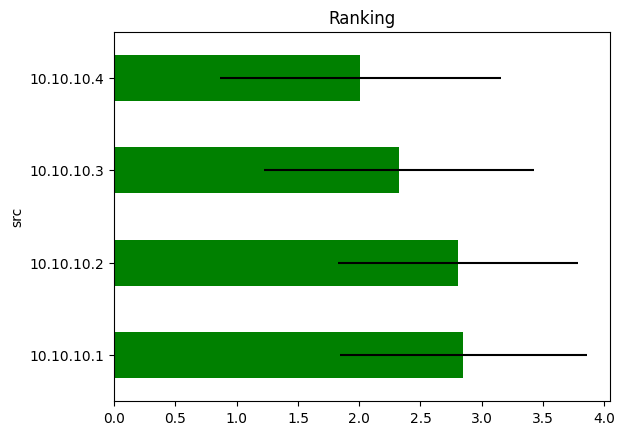

In [23]:
qual = ranks_per_src.groupby(src_label).agg(['mean', 'std']).droplevel(0, 1)
qual.plot(kind = "barh", y = "mean", legend = False, xerr = "std", title = "Ranking", color='green')

plt.show()

Charts of the 4 distributions.

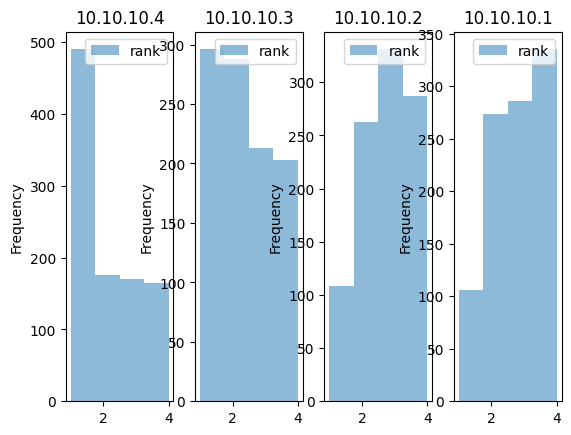

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=4)

srcs = ranking_summary.filter([src_label]).drop_duplicates()
data1 = ranks_per_src.where(ranks_per_src[src_label] == srcs.index[0])
data1.plot.hist(ax = axes[0], bins=4, alpha=0.5, title = srcs.index[0])
data2 = ranks_per_src.where(ranks_per_src[src_label] == srcs.index[1])
data2.plot.hist(ax = axes[1], bins=4, alpha=0.5, title = srcs.index[1])
data3 = ranks_per_src.where(ranks_per_src[src_label] == srcs.index[2])
data3.plot.hist(ax = axes[2], bins=4, alpha=0.5, title = srcs.index[2])
data4 = ranks_per_src.where(ranks_per_src[src_label] == srcs.index[3])
data4.plot.hist(ax = axes[3], bins=4, alpha=0.5, title = srcs.index[3])

plt.show()

It is possible now to objectively decide to keep on only the lines 10.10.10.4 (the fastest by far) and 10.10.10.3 as a backup.  
The other 2 lines are much slower and can be discarded.